<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 3

### <center> Автор материала: Жеребцов Алексей 

## <center> Индивидуальный проект по анализу данных </center>

**План исследования**
 - Описание набора данных и признаков
 - Первичный анализ признаков
 - Первичный визуальный анализ признаков
 - Закономерности, "инсайты", особенности данных
 - Предобработка данных
 - Создание новых признаков и описание этого процесса
 - Кросс-валидация, подбор параметров
 - Построение кривых валидации и обучения 
 - Прогноз для тестовой или отложенной выборки
 - Оценка модели с описанием выбранной метрики
 - Выводы
 
 Более детальное описание [тут](https://goo.gl/cJbw7V).

## Часть 0. Импорт библиотек ##

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from statsmodels.stats.weightstats import *
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import scipy.stats as st
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import csr_matrix, hstack
from sklearn.linear_model import Ridge, Lasso, SGDRegressor
from sklearn.model_selection import GridSearchCV, KFold, validation_curve, learning_curve
from sklearn.metrics import mean_absolute_error, median_absolute_error, r2_score

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

##  Часть 1. Описание набора данных и признаков

### Источник данных: ###
Для исследования использован датасет с [kaggle](https://www.kaggle.com/philipjames11/dark-net-marketplace-drug-data-agora-20142015). В датасете содержится более 100000 обьявлений, размёщенных на торговой онлайн-площадке Agora (доступ возможен был через Tor) в период с 2014 по 2015 гг. На данный момент онлайн-площадка не функционирует.

### Цели и задачи: ###
#### Цель: ####
Предсказать стоимость указанную в обьявлении по остальным признакам
#### Задачи: ####
    1 Проанализировать признаки обьявления в датасете
    2 Отобрать наиболее значимые в прогнозировании цены
    3 Построить и обучить модель восстановления регрессии для цены

### Признаки: ###
#### Целевой признак:
    Price - стоимость товара или услуги, указанная в объявлении
#### Объясняющие:
    Vendor - аккаунт с которого размещено объявление
    Category - Категория, к которой относится обьявление (имеет вложенную иерархическую структуру /.../.../... до 4 уровней в глубину)
    Item - название обьявления
    ItemDescription - описание обьявления
    Origin - локация происхождения обьявления
    Destination - локация назначения обьявления
    Rating - рэйтинг аккаунта с которого размещено обьявление
    Remarks - дополнительные замечание (в датасете они либо пустые, либо "Average price may be skewed outliar > .5 BTC found")
    

In [2]:
DATA_PATH='archive/Agora.csv'

In [3]:
data=pd.read_csv(DATA_PATH, encoding="latin1")
data.columns = [x.replace(" ", "") for x in data.columns]
data.head()

,Vendor,Category,Item,ItemDescription,Price,Origin,Destination,Rating,Remarks
0,CheapPayTV,Services/Hacking,12 Month HuluPlus gift Code,12-Month HuluPlus Codes for $25. They are wort...,0.05027025666666667 BTC,Torland,NaN,4.96/5,NaN
1,CheapPayTV,Services/Hacking,Pay TV Sky UK Sky Germany HD TV and much mor...,Hi we offer a World Wide CCcam Service for En...,0.152419585 BTC,Torland,NaN,4.96/5,NaN
2,KryptykOG,Services/Hacking,OFFICIAL Account Creator Extreme 4.2,Tagged Submission Fix Bebo Submission Fix Adju...,0.007000000000000005 BTC,Torland,NaN,4.93/5,NaN
3,cyberzen,Services/Hacking,VPN > TOR > SOCK TUTORIAL,How to setup a VPN > TOR > SOCK super safe enc...,0.019016783532494728 BTC,NaN,NaN,4.89/5,NaN
4,businessdude,Services/Hacking,Facebook hacking guide,. This guide will teach you how to hack Faceb...,0.062018073963963936 BTC,Torland,NaN,4.88/5,NaN


##  Часть 2. Первичный анализ признаков ##

### Получение общей информации по  датасету: ###

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109689 entries, 0 to 109688
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   Vendor           109689 non-null  object
 1   Category         109689 non-null  object
 2   Item             109687 non-null  object
 3   ItemDescription  109662 non-null  object
 4   Price            109684 non-null  object
 5   Origin           99807 non-null   object
 6   Destination      60528 non-null   object
 7   Rating           109674 non-null  object
 8   Remarks          12616 non-null   object
dtypes: object(9)
memory usage: 7.5+ MB


Видно, что признаки Vendor, Category, Item, ItemDescription, Rating и целевая переменная Price не содержат,
или содержат очень малое количество пропусков в данных. Обьявление с пропусками в этих признаках удалим,
из-за их незначительного количества они не должны существенно повлиять на дальнейшее исследование. 

In [5]:
# Remove nan for Item, ItemDescription, Rating and Price
data = data[pd.notnull(data['Item'])]
data = data[pd.notnull(data['ItemDescription'])]
data = data[pd.notnull(data['Price'])]
data = data[pd.notnull(data['Rating'])]

### Числовые признаки: ###
Обработаем и переведём признаки Price и Rating в числовой формат:

In [6]:
#Price to numeric
data['Price']=data['Price'].str.replace('BTC', '')
data['Price']=data['Price'].str.replace(' ', '')
data=data[~data['Price'].str.contains(r'[^0123456789.]')]
data['Price'] = pd.to_numeric(data['Price'])

При обработке рейтинга следует учесть, что есть продавцы, у которых на момент обьявления 0 сделок ([0 deals]) либо количество сделок очень маленькое для составления рейтинга. Создадим для таких продавцов отдельный признак 'No_Deals' - который будет равняться 1 в случае малого числа сделок и 0 в противоположном случае. Рейтинг же таких продавцов сделаем равным среднему значению по всему датасету.

In [7]:
#Rating to numeric and create No_deals
data['Rating']= data['Rating'].str.split('/').str[0]
data['Rating']=data['Rating'].str.replace(r'(~)','')
data['No_deals']=0
data.loc[data[data['Rating'].str.contains(r'(deal)')].index,['No_deals']]=1
mean_rating=pd.to_numeric(data[~data['Rating'].str.contains(r'(deal)')]['Rating']).mean()
data.loc[data[data['Rating'].str.contains(r'(deal)')].index,['Rating']]=str(mean_rating)
data['Rating']=data['Rating'].astype(float)

In [8]:
data[['Rating','Price']].describe()

,Rating,Price
count,109587.000000,1.095870e+05
mean,4.888125,2.217668e+01
std,0.340763,1.038115e+03
min,0.000000,1.000000e-07
25%,4.888125,1.233610e-01
50%,4.968000,3.825643e-01
75%,5.000000,1.329998e+00
max,5.000000,1.303961e+05


### Категориальные признаки: ###
Под категориальные признаки в исследуемом датасете попадают Vendor, Category, Origin, Destination.

Признак Category содержит вложенный список подкатегорий, глубиной до 4-х. Разобьём подкатегории на 4 отдельных признака (subcat1/subcat2/subcat3/subcat4).

In [9]:
data = pd.concat([data,data.Category.str.split('/', expand=True)], axis=1)
data = data.rename(columns={0: 'subcat1', 1: 'subcat2',2: 'subcat3', 3: 'subcat4'})
data=data.drop(['Category'],axis=1)

Обработаем признаки Origin и Destination

In [10]:
for x in ["Origin","Destination"]:
    data[x] = data[x].str.capitalize().str.replace('[^\w\s]','') # 1
    data[x] = data[x].str.replace(r"\bonly\b", '').str.strip() # 2 
    data.loc[data[x].str.contains(r"(?i)world|\b(?i)word\b|(?i)global",na=False),x] = "Worldwide" # 3
    data.loc[data[x].str.contains(r"(?i)kingdom",na=False),x] = "Uk" # 4
    data.loc[data[x].str.contains(r"(?i)(\bunited states\b)|\b(?i)us\b",na=False),x] = "Usa" # 5
data['Origin']=data['Origin'].fillna('OriginNotDefined')
data['Destination']=data['Destination'].fillna('DestNotDefined')

In [11]:
data[['Vendor','subcat1','subcat2','subcat3','subcat4','Origin','Destination']].describe()

,Vendor,subcat1,subcat2,subcat3,subcat4,Origin,Destination
count,109587,109587,107051,77281,276,109587,109587
unique,3184,14,42,56,3,306,565
top,optiman,Drugs,Cannabis,Weed,Sex,Usa,DestNotDefined
freq,881,92989,31150,21259,145,33818,49088


### Текстовые признаки ###
Под текстовые признаки попадают Item и ItemDescription. Проведём довольно грубую обаботку текстовых данных, убрав все знаки, не являющиеся буквами или цифрами.

In [12]:
data['Item']=data['Item'].str.replace(r'[^0-9a-zA-Z ]','')
data['ItemDescription']=data['ItemDescription'].str.replace(r'[^0-9a-zA-Z ]','')

### Бинарные признаки ###
Под бинарный признак попадает вышесозданный нами признак No_Deals, а так же приведём к бинарному виду признак Remarks, который судя по описанию либо пустой, либо говорит о том что средняя цена может быть искажена.

In [13]:
data['Remarks']=data['Remarks'].fillna('0')
data.loc[data[data['Remarks']!='0'].index,['Remarks']]='1'
data['Remarks']=pd.to_numeric(data['Remarks'])

In [14]:
data.groupby('No_deals')['Price'].median()

No_deals
0    0.387692
1    0.317335
Name: Price, dtype: float64

In [15]:
data.groupby('Remarks')['Price'].median()

Remarks
0    0.299886
1    5.322814
Name: Price, dtype: float64

##  Часть 3. Первичный визуальный анализ признаков

### Целевой признак: ###
Построим распределение целевого признака

<AxesSubplot: xlabel='Price', ylabel='Density'>

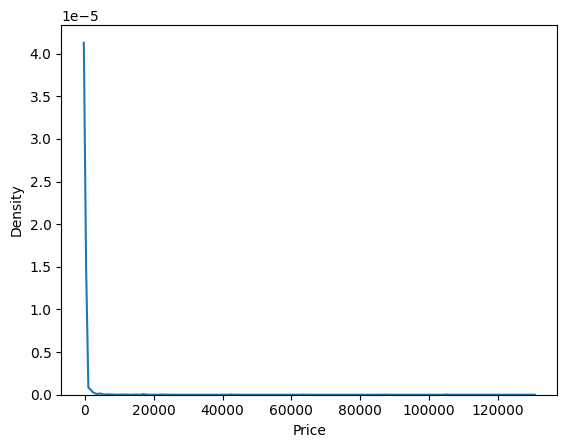

In [16]:
sns.distplot(data['Price'],hist=False)

В распределении присутствуют очень большие цены. Причина скорее всего в том, что не везде цены указаны в BTC. Исходя из этого предположения попробуем отфильтровать выбросы, находящиеся выше 95% квантили. Так же слишком маленькие цены могут проставляться, в случае когда цена договорная. Поэтому отфильтруем выбросы, находящиеся ниже 5% квантили

<AxesSubplot: xlabel='Price', ylabel='Density'>

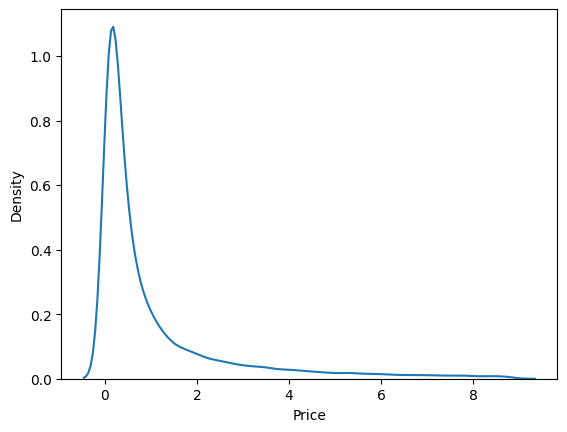

In [17]:
quantiles=data['Price'].quantile([0.05,0.95])
sns.distplot(data[(data['Price']<quantiles[0.95])&(data['Price']>quantiles[0.05])]['Price'],hist=False)

Распределение стало более "гладким", так что скорее всего наше предположение о выбросах верно. Попутно удалим эти выбросы из исходного датасета. И сравним логарифм нашего распределения цены с нормальным распределением.

In [18]:
#Delete quantiles
data=data[(data['Price']<quantiles[0.95])&(data['Price']>quantiles[0.05])]

<AxesSubplot: xlabel='Price', ylabel='Density'>

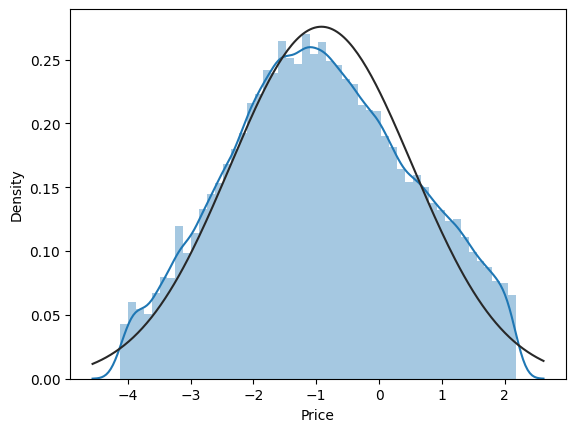

In [19]:
sns.distplot(data['Price'].map(np.log),fit=st.norm)

In [20]:
print('p-value ', st.shapiro(data['Price'].map(np.log))[1]*100, '%')

p-value  0.0 %


На первый взгляд логарифм нашего распределение цены напоминает нормальное распределение, однако тест Шапиро-Уилка не позволяет статистически принять эту гипотезу.

### Зависимость цены от происхождения('Origin') и назначения('Destination'):

In [21]:
Top_Origin=data.groupby('Origin')['Price'].count().sort_values(ascending=False).axes[0].values[:15]
Top_Destination=data.groupby('Destination')['Price'].count().sort_values(ascending=False).axes[0].values[:15]

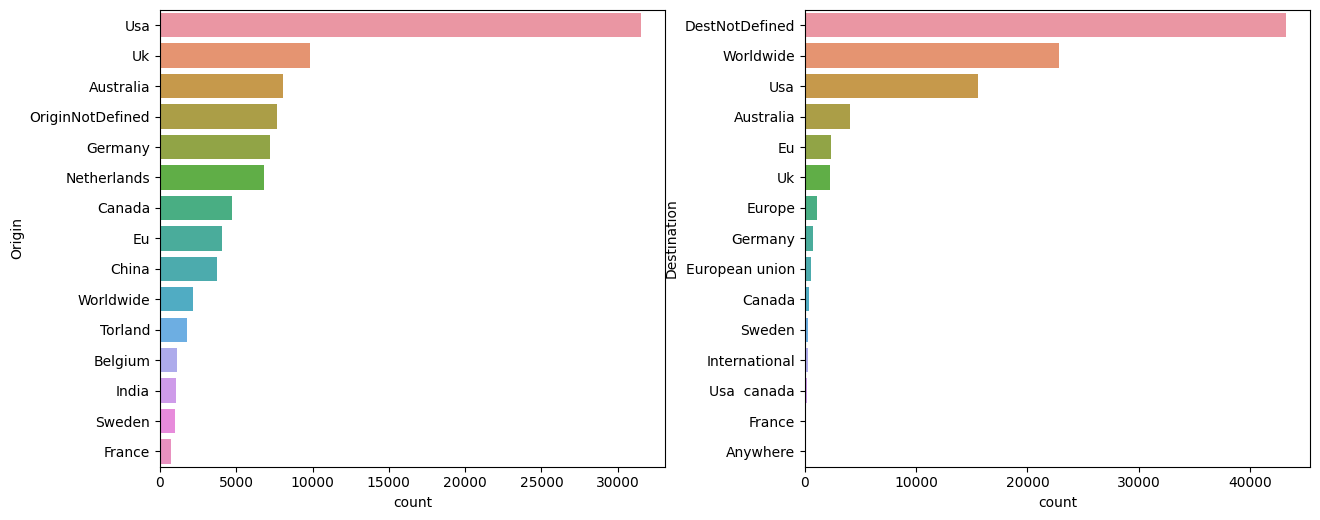

In [22]:
f, (count_orig, count_dest) = plt.subplots(1,2,figsize=(13,5))
count_orig=sns.countplot(y='Origin',data=data[data['Origin'].isin(Top_Origin)],ax=count_orig, order=Top_Origin)
count_dest=sns.countplot(y='Destination',data=data[data['Destination'].isin(Top_Destination)],ax=count_dest, order=Top_Destination)
plt.tight_layout(pad=0)
plt.show()

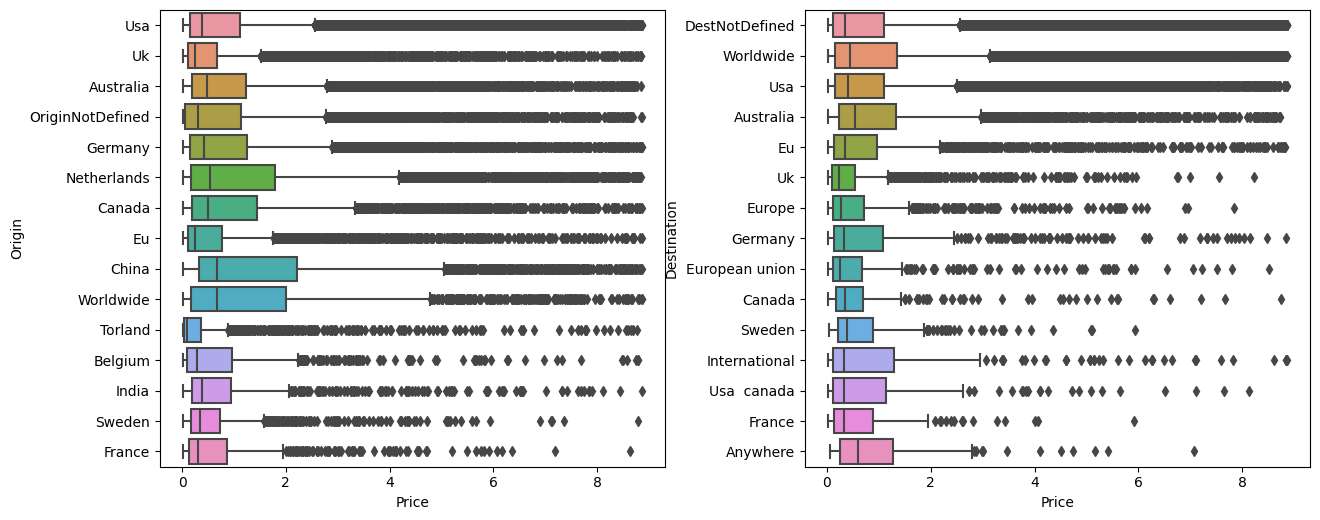

In [23]:
f, (box_orig, box_dest) = plt.subplots(1,2,figsize=(13,5))
box_orig=sns.boxplot(x='Price',y='Origin',data=data[data['Origin'].isin(Top_Origin)],ax=box_orig, order=Top_Origin)
box_dest=sns.boxplot(x='Price',y='Destination',data=data[data['Destination'].isin(Top_Destination)],ax=box_dest, order=Top_Destination)
plt.tight_layout(pad=0)
plt.show()

In [24]:
sort_subcat1=data.groupby('subcat1')['Price'].count().sort_values(ascending=False).axes[0].values

### Распределение цены в зависимости от категории
Вначале построим график числа обьявлений в зависимости от категории, затем построим график распределения цены в зависимости от категории

<AxesSubplot: xlabel='count', ylabel='subcat1'>

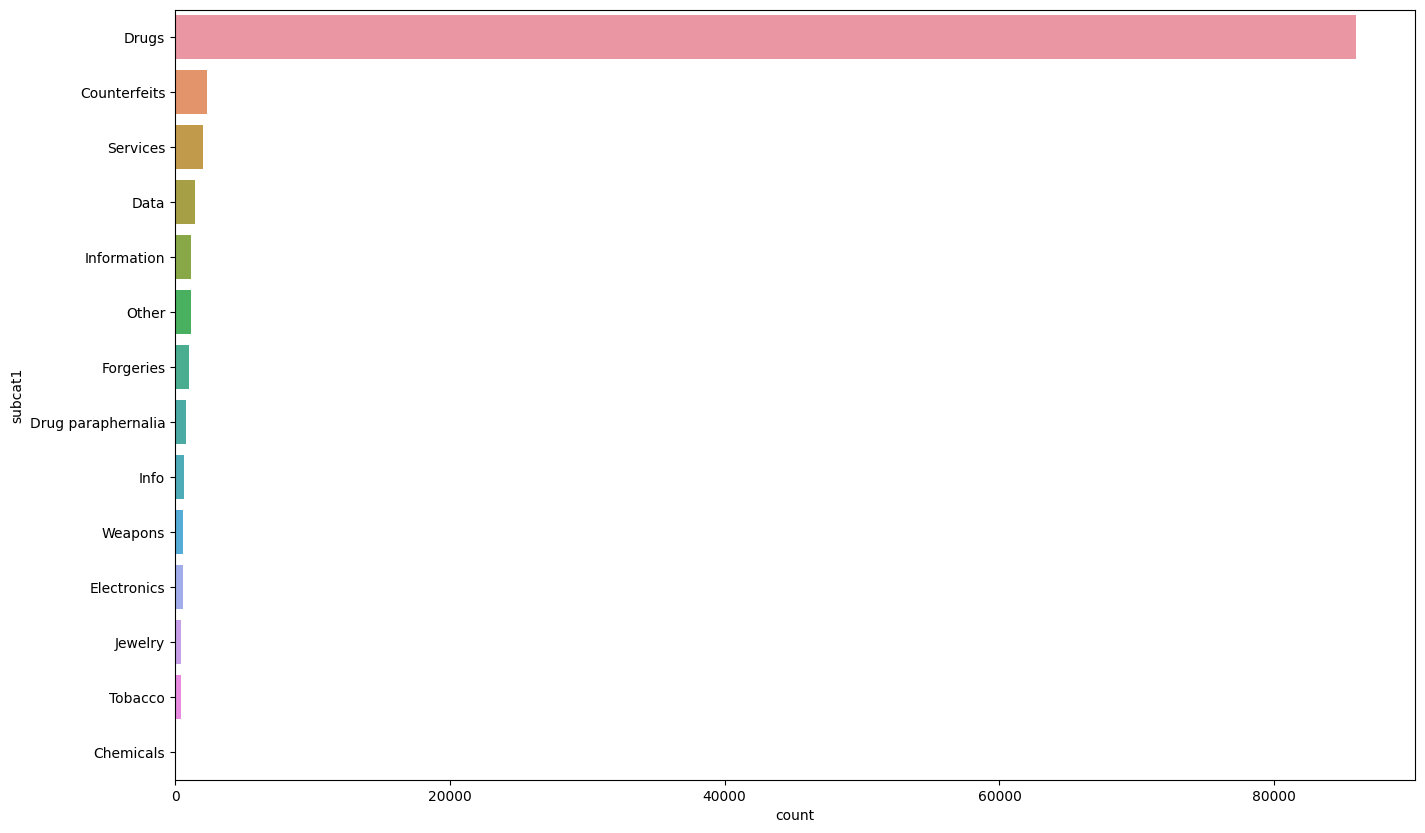

In [25]:
fig, axes = plt.subplots(figsize=(16, 10))
sns.countplot(y='subcat1',data=data,order=sort_subcat1)

<AxesSubplot: xlabel='Price', ylabel='subcat1'>

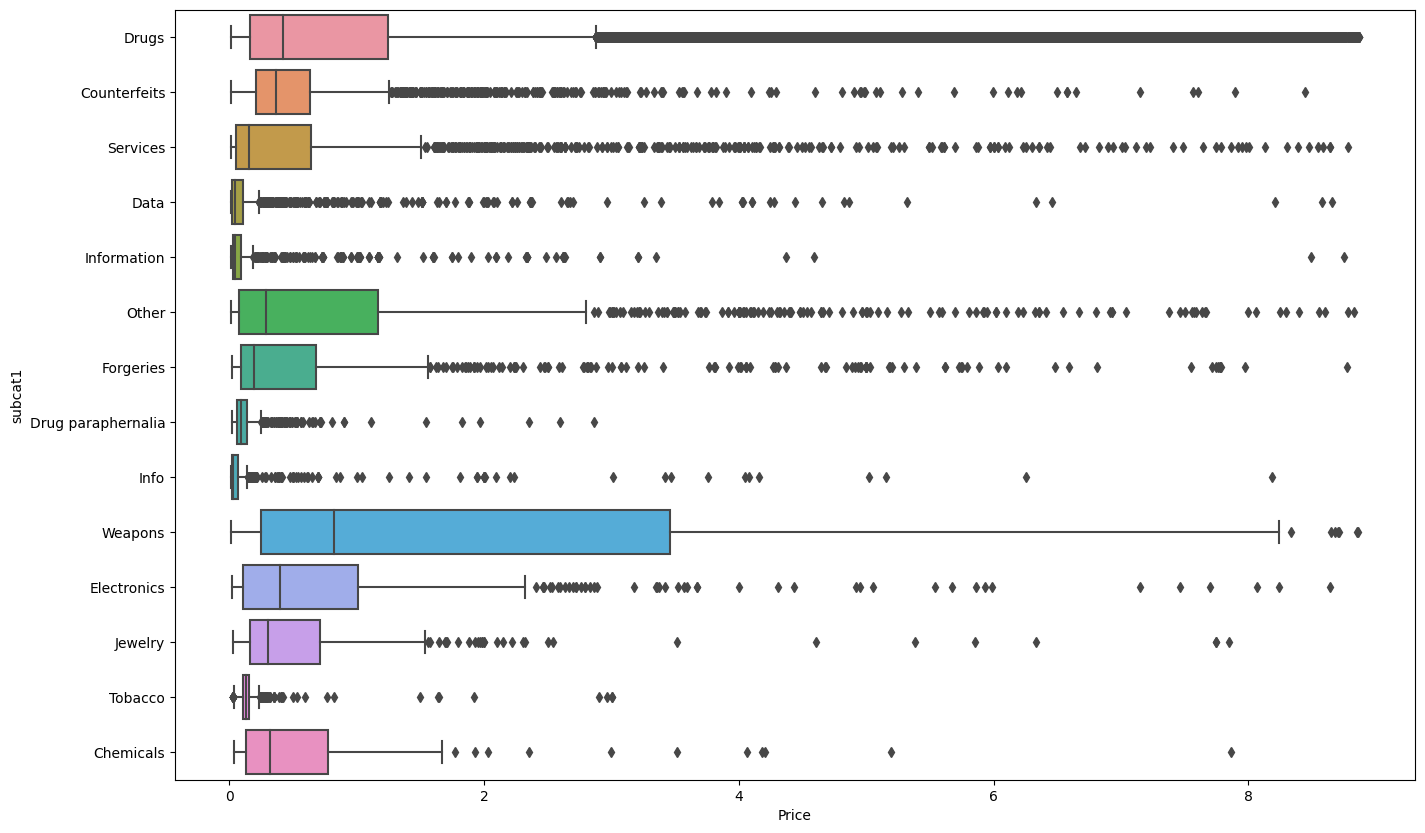

In [26]:
fig, axes = plt.subplots(figsize=(16, 10))
sns.boxplot(x='Price',y='subcat1',data=data,order=sort_subcat1)

Для 5 наиболее встречаемых категорий построим зависимость распределения цены от подкатегории subcat2

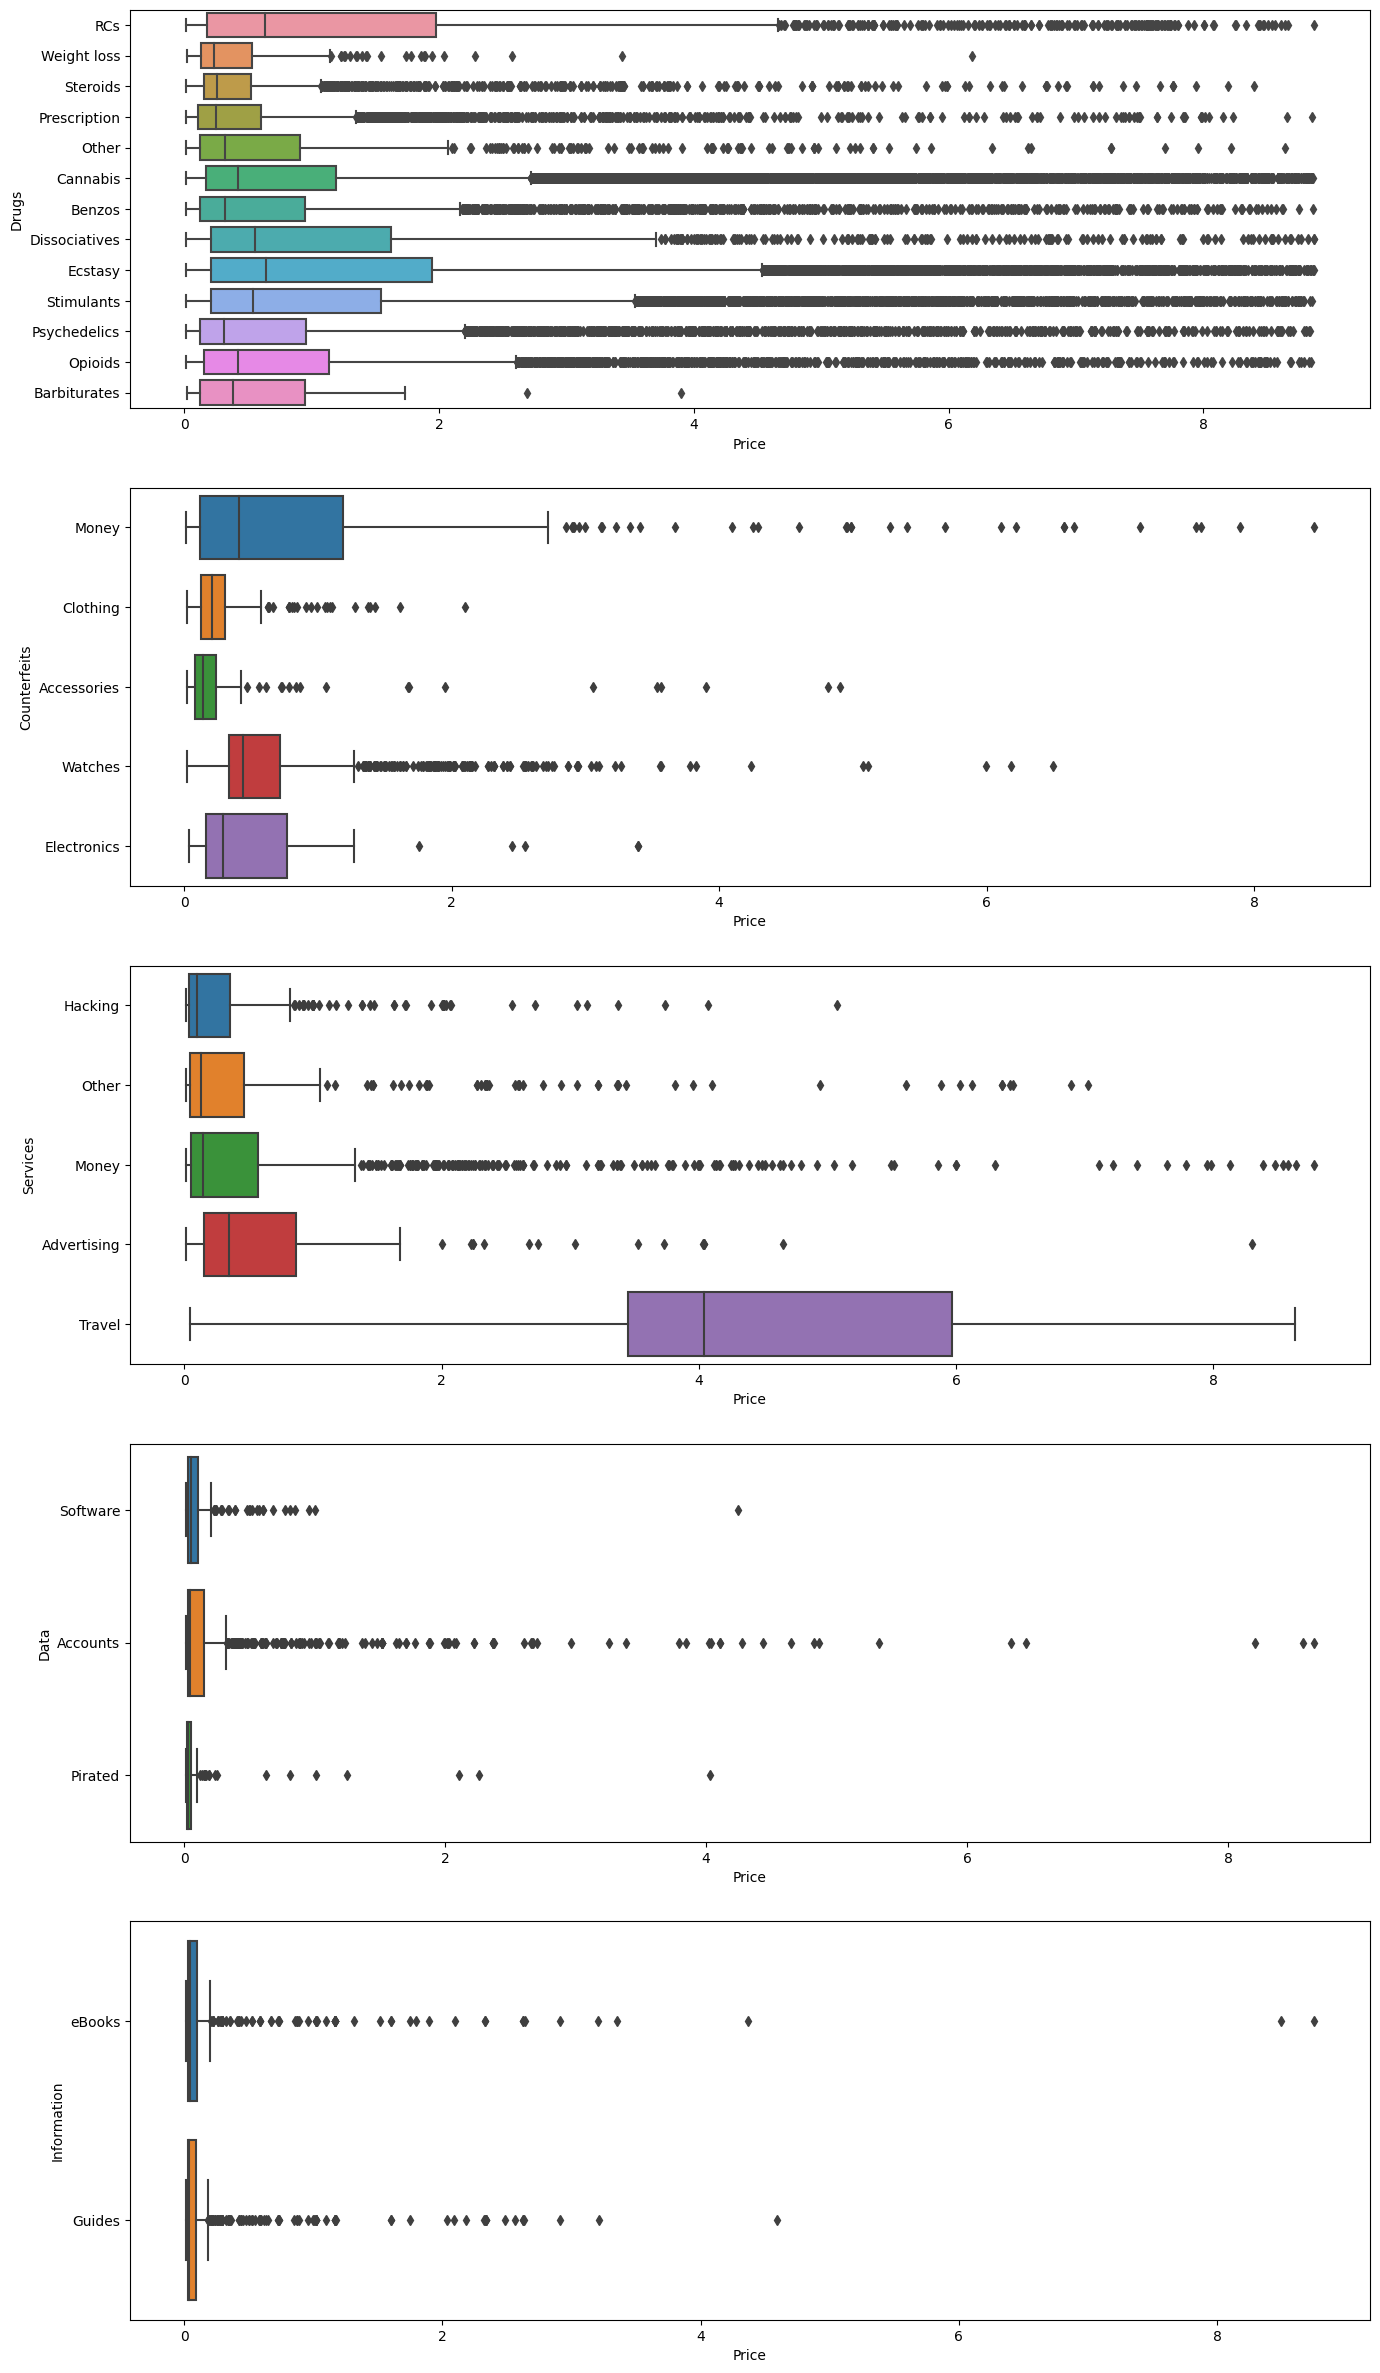

In [27]:
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(16, 30))
for idx,category in enumerate(sort_subcat1[:5]):
    sns.boxplot(x='Price',y='subcat2',data=data[data['subcat1']==category], ax=axes[idx])
    axes[idx].set_ylabel(category)

### Числовые признак рэйтинг('Rating'):
Построим распределение числового признака

<AxesSubplot: xlabel='Rating', ylabel='Density'>

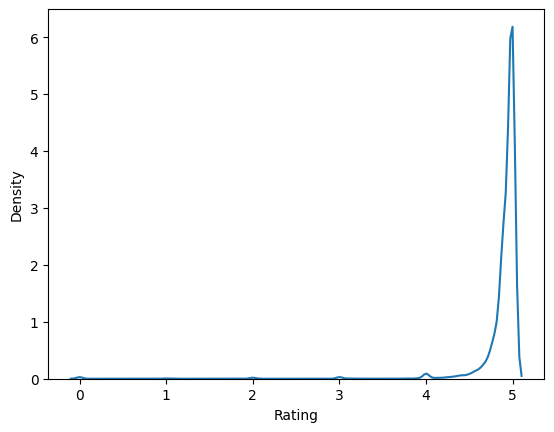

In [28]:
sns.distplot(data['Rating'],hist=False)

Видно, что это усреднённые дискретные значения от 1 до 5. Округлим рейтинг до целых чисел, получив таким образом вместо числового, категориальный признак.

In [29]:
data['Rating']=data['Rating'].apply(round)
data['Rating']=data['Rating'].astype(str)

<AxesSubplot: xlabel='Rating', ylabel='count'>

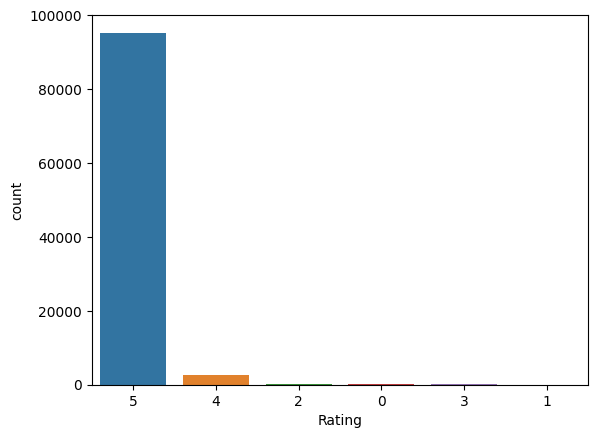

In [30]:
sns.countplot(x='Rating',data=data)

Видно что в большинстве случаев рейтин продавцов близок к максимальному.

##  Часть 4. Закономерности, "инсайты", особенности данных

Из анализа признаков можно сделать следующие выводы:
    1. Значительная часть пользователей находится в США
    2. Большинство обьявлений связано с наркотиками
    3. Медианная цена умеренно варьируется в зависимости от страны происхождения
    4. Медианная цена значительно варьирутеся в зависимости от категории и подкатегории
    5. Как по странам так и по категориям данные содержат значительное число ценовых выбросов
    6. Третий и четвертый уровень категорий отмечен в незначительном числе обьявлений, его можно не принимать во внимание
    7. Для нового бинарного признака No_deals медианная цена изменяется незначительно
    8. Для бинарного признака Remarks медианная цена тличается значительно
    9. Присутствуют текстовые признаки, в которых содержится информация, которая должна влиять на цену
    10. Небольшой прирост медианной цены заметен либо в далёких локация, таких как австралия, либо если место назначения не имеет значения

##  Часть 5. Предобработка данных 

Разобьём данные на признаки и целевую переменную

In [31]:
y=data['Price']
X=data.drop(['Price'],axis=1)

Удалим subcat3 и subcat4, про них говорилось выше. Пропуски во второй подкатегории заменим на 'Other'

In [32]:
X=X.drop(['subcat3','subcat4'],axis=1)
X['subcat2']=X['subcat2'].fillna('Other')

Разобьём данные на тренировочные и тестовые

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [34]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98627 entries, 0 to 109688
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Vendor           98627 non-null  object
 1   Item             98627 non-null  object
 2   ItemDescription  98627 non-null  object
 3   Origin           98627 non-null  object
 4   Destination      98627 non-null  object
 5   Rating           98627 non-null  object
 6   Remarks          98627 non-null  int64 
 7   No_deals         98627 non-null  int64 
 8   subcat1          98627 non-null  object
 9   subcat2          98627 non-null  object
dtypes: int64(2), object(8)
memory usage: 8.3+ MB


### Извлечение текстовых признаков Item и ItemDescription

In [35]:
I_count_vect=CountVectorizer(ngram_range=(1, 2),max_features=100000)
X_train_Item=I_count_vect.fit_transform(X_train['Item'])
X_test_Item=I_count_vect.transform(X_test['Item'])

In [36]:
Id_count_vect=CountVectorizer(ngram_range=(1, 2),max_features=100000)
X_train_ItemDesc=Id_count_vect.fit_transform(X_train['ItemDescription'])
X_test_ItemDesc=Id_count_vect.transform(X_test['ItemDescription'])

In [37]:
X_train_text=csr_matrix(hstack((X_train_Item,X_train_ItemDesc)))
X_test_text=csr_matrix(hstack((X_test_Item,X_test_ItemDesc)))

### Извлечение признаков по категориям

In [38]:
#Vendor
Vend_count_vect=CountVectorizer()
X_train_Vend=Vend_count_vect.fit_transform(X_train['Vendor'])
X_test_Vend=Vend_count_vect.transform(X_test['Vendor'])

In [39]:
#subcat1
Sub1_count_vect=CountVectorizer()
X_train_Sub1=Sub1_count_vect.fit_transform(X_train['subcat1'])
X_test_Sub1=Sub1_count_vect.transform(X_test['subcat1'])

In [40]:
#subcat2
Sub2_count_vect=CountVectorizer()
X_train_Sub2=Sub2_count_vect.fit_transform(X_train['subcat2'])
X_test_Sub2=Sub2_count_vect.transform(X_test['subcat2'])

In [41]:
#Origin
Orig_count_vect=CountVectorizer()
X_train_Orig=Orig_count_vect.fit_transform(X_train['Origin'])
X_test_Orig=Orig_count_vect.transform(X_test['Origin'])

In [42]:
#Destination
Dest_count_vect=CountVectorizer()
X_train_Dest=Dest_count_vect.fit_transform(X_train['Destination'])
X_test_Dest=Dest_count_vect.transform(X_test['Destination'])

In [43]:
#Rating
RatingOhe=OneHotEncoder()
X_train_Rating=RatingOhe.fit_transform(X_train['Rating'].values.reshape(-1, 1))
X_test_Rating=RatingOhe.transform(X_test['Rating'].values.reshape(-1, 1))

In [44]:
X_train_categ=csr_matrix(hstack((X_train_Vend,X_train_Sub1,X_train_Sub2,X_train_Orig,X_train_Dest,X_train_Rating)))
X_test_categ=csr_matrix(hstack((X_test_Vend,X_test_Sub1,X_test_Sub2,X_test_Orig,X_test_Dest,X_test_Rating)))

Построим общую sparse матрицу для всех обучающих и тестовых признаков

In [45]:
X_train_sparse=csr_matrix(hstack((X_train_text,X_train_categ,X_train[['No_deals','Remarks']])))
X_test_sparse=csr_matrix(hstack((X_test_text,X_test_categ,X_test[['No_deals','Remarks']])))

### Прологарифмируем целевой признак, т.к. распределение его логарифма более похоже на нормальное

In [46]:
y_train=np.log(y_train)

In [47]:
y_test=np.log(y_test)

##  Часть 6. Создание новых признаков и описание этого процесса

При первичном анализе данных в части 1 был получен новый бинарный признак No_deals и описан этот процесс

##  Часть 7. Кросс-валидация, подбор параметров

В сформированном окончательном наборе данных мы получили очень большое число разреженных признаков, относительно большую выборку данных, плюс среди данных имеется некоторое количество выбросов, опираясь на эту особенность попробуем построить модель восстановления регрессии на основе SGDRegressor. В качестве функции потерь выберем функцию Губера. За метрику ошибки возьмём r2_score

In [48]:
kf = KFold(n_splits=3, shuffle=True, random_state=18)

model = SGDRegressor(loss='huber',random_state=18, learning_rate='optimal', max_iter=100)

params = {'alpha': np.linspace(0.000005,0.0001, num=10)}

grid = GridSearchCV(model, param_grid=params, scoring='r2', cv=kf, verbose=3)
grid.fit(X_train_sparse,y_train)
grid.best_score_

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3] END .......................alpha=5e-06;, score=0.629 total time=   0.9s
[CV 2/3] END .......................alpha=5e-06;, score=0.595 total time=   0.8s
[CV 3/3] END .......................alpha=5e-06;, score=0.631 total time=   0.8s
[CV 1/3] END ......alpha=1.5555555555555555e-05;, score=0.684 total time=   0.5s
[CV 2/3] END ......alpha=1.5555555555555555e-05;, score=0.659 total time=   0.5s
[CV 3/3] END ......alpha=1.5555555555555555e-05;, score=0.676 total time=   0.5s
[CV 1/3] END .......alpha=2.611111111111111e-05;, score=0.677 total time=   0.4s
[CV 2/3] END .......alpha=2.611111111111111e-05;, score=0.676 total time=   0.4s
[CV 3/3] END .......alpha=2.611111111111111e-05;, score=0.684 total time=   0.4s
[CV 1/3] END ......alpha=3.6666666666666666e-05;, score=0.689 total time=   0.4s
[CV 2/3] END ......alpha=3.6666666666666666e-05;, score=0.676 total time=   0.3s
[CV 3/3] END ......alpha=3.6666666666666666e-05;

0.683727773407803

In [49]:
grid.best_estimator_

SGDRegressor(alpha=3.6666666666666666e-05, learning_rate='optimal',
             loss='huber', max_iter=100, random_state=18)

##  Часть 8. Построение кривых валидации и обучения 

In [50]:
alphas = np.linspace(0.000005,0.0001, num=10)
val_train, val_test = validation_curve(model, X_train_sparse, y_train, param_name='alpha', param_range=alphas, cv=kf, scoring='r2')

def plot_with_err(x, data, **kwargs):
    mu, std = data.mean(1), data.std(1)
    lines = plt.plot(x, mu, '-', **kwargs)
    plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                     facecolor=lines[0].get_color(), alpha=0.2)

In [51]:
train_sizes = np.linspace(0.05, 1, 10)
N_train, tr_train, tr_test = learning_curve(model, X_train_sparse, y_train, train_sizes=train_sizes, cv=kf, scoring='r2')

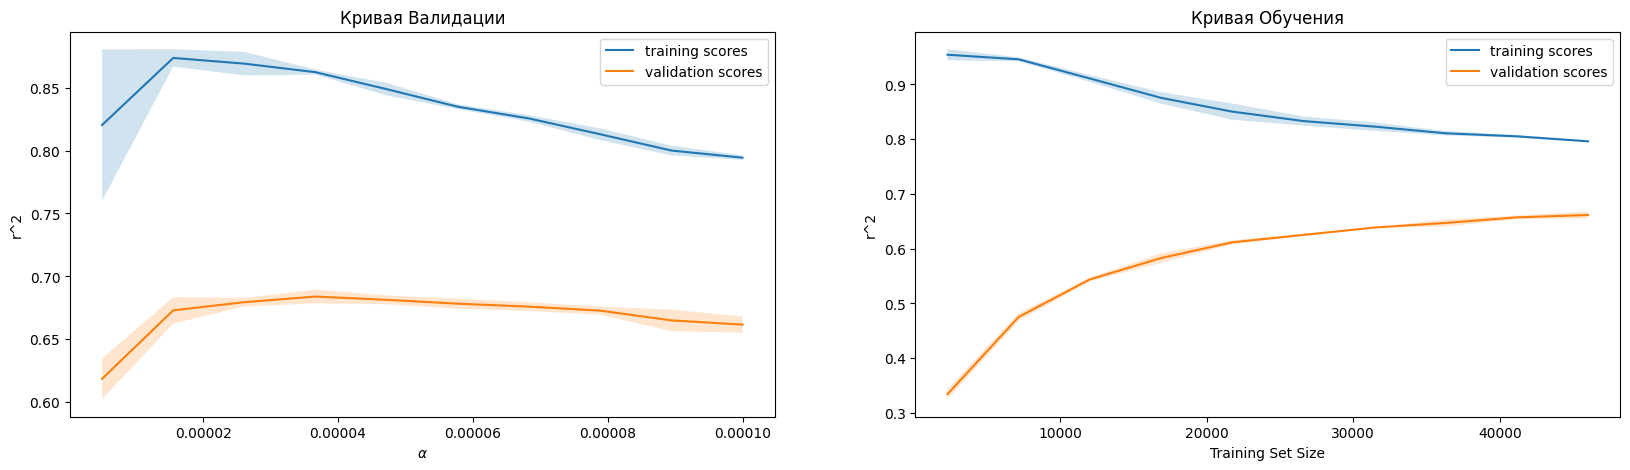

In [52]:
fig = plt.figure(figsize=(20, 5))
ax1 = fig.add_subplot(121)
ax1.set_title('Кривая Валидации')
plot_with_err(alphas, val_train, label='training scores')
plot_with_err(alphas, val_test, label='validation scores')
plt.xlabel(r'$\alpha$'); plt.ylabel('r^2')
plt.legend();


ax2 = fig.add_subplot(122)
ax2.set_title('Кривая Обучения')
plot_with_err(N_train, tr_train, label='training scores')
plot_with_err(N_train, tr_test, label='validation scores')
plt.xlabel('Training Set Size'); plt.ylabel('r^2')
plt.legend()

##  Часть 9. Прогноз для тестовой или отложенной выборки

In [53]:
r2_score(y_test, grid.predict(X_test_sparse))

0.7070130807252031

##  Часть 10. Оценка модели с описанием выбранной метрики

Судя по кривым валидации имеются небольшие признаки переобучения,однако прогноз на тестовой выборке оказался рядом с лучшим прогнозом на кроссвалидации. Судя по кривой обучения, при данном наборе признаков возможно недостаточно данных для обучения, т.к. качество модели рассчитанное по r2_score приемлимо, но недостаточно. r2_score метрика была выбрана, т.к. мы имеем выбросы в разбросе цен, она позволяет их лучше учесть, при оценке качества модели.

## Часть 11. Выводы 

Полученная модель имеет предсказание оценки качества приемлимое, но недостаточное. Возможно необходим больший набор данных. Так же в этом датасете очень важными являются признаки содержащиеся в текстовых полях Item и ItemDescription, в рассматриваемом исследовании они были извлечены недостаточно информативно.